In [28]:
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from urllib.request import urlretrieve
from PIL import Image

# Klasör oluşturma
def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

# Görselleri indir ve işleme
def download_images_unique(base_url, output_folder, processed_folder, num_pages=5, images_needed=50, size=(128, 128)):
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    create_folder(output_folder)
    create_folder(processed_folder)
    downloaded_urls = set()  # İndirilen görsellerin URL'lerini takip etmek için bir set
    total_downloaded = 0  # Toplam indirilen resim sayısı

    for page in range(1, num_pages + 1):
        if total_downloaded >= images_needed:
            print(f"{images_needed} görsel indirildi. İşlem sonlandırılıyor.")
            break

        url = f"{base_url}?pi={page}"
        driver.get(url)
        time.sleep(3)  # Sayfa yüklenmesi için bekleme

        # Sayfadaki görselleri bul
        images = driver.find_elements(By.CSS_SELECTOR, "img.p-card-img")
        for idx, img in enumerate(images):
            if total_downloaded >= images_needed:
                break  # Hedef sayıya ulaşıldığında durdur

            img_url = img.get_attribute("src")
            if img_url and "product-placeholder" not in img_url and img_url not in downloaded_urls:
                file_name = os.path.join(output_folder, f"image_page{page}_{idx + 1}.jpg")
                processed_file_name = os.path.join(processed_folder, f"image_page{page}_{idx + 1}.jpg")
                try:
                    # Görseli indir
                    urlretrieve(img_url, file_name)
                    downloaded_urls.add(img_url)  # URL'yi indirilenlere ekle
                    total_downloaded += 1
                    print(f"İndirildi: {file_name} ({total_downloaded}/{images_needed})")
                    
                    # Görseli işleme ve boyutlandırma
                    img = Image.open(file_name)
                    img = img.convert("RGB")  # RGB formatına dönüştür
                    img = img.resize(size)   # Boyutlandır
                    img.save(processed_file_name)  # İşlenmiş klasöre kaydet
                except Exception as e:
                    print(f"İndirilemedi veya işlenemedi: {img_url}, Hata: {e}")
            elif img_url in downloaded_urls:
                print(f"Tekrarlanan URL atlandı: {img_url}")

    driver.quit()

# Kullanım
urls = {
    "Sneaker": "https://www.trendyol.com/kadin-sneaker-x-g1-c1172",
    "Babet": "https://www.trendyol.com/kadin-babet-x-g1-c113",
    "Bot": "https://www.trendyol.com/kadin-bot-x-g1-c1025",
    "Topuklu Ayakkabı": "https://www.trendyol.com/kadin-topuklu-ayakkabi-x-g1-c107"
}

output_folder_base = "trendyol_images"       # Orijinal görsellerin kaydedileceği ana klasör
processed_folder_base = "processed_images"  # İşlenmiş görsellerin kaydedileceği ana klasör

# Her bir URL için işlemi başlat
for category, url in urls.items():
    raw_folder = os.path.join(output_folder_base, category)          # Kategori bazında klasör (orijinal)
    processed_folder = os.path.join(processed_folder_base, category)  # Kategori bazında klasör (işlenmiş)
    print(f"\n{category} kategorisinden görseller indiriliyor...")
    download_images_unique(url, raw_folder, processed_folder, num_pages=5, images_needed=50)


Sneaker kategorisinden görseller indiriliyor...
İndirildi: trendyol_images\Sneaker\image_page1_1.jpg (1/50)
İndirildi: trendyol_images\Sneaker\image_page1_2.jpg (2/50)
İndirildi: trendyol_images\Sneaker\image_page1_3.jpg (3/50)
İndirildi: trendyol_images\Sneaker\image_page1_4.jpg (4/50)
İndirildi: trendyol_images\Sneaker\image_page1_5.jpg (5/50)
İndirildi: trendyol_images\Sneaker\image_page1_6.jpg (6/50)
İndirildi: trendyol_images\Sneaker\image_page1_7.jpg (7/50)
İndirildi: trendyol_images\Sneaker\image_page1_8.jpg (8/50)
İndirildi: trendyol_images\Sneaker\image_page1_9.jpg (9/50)
İndirildi: trendyol_images\Sneaker\image_page1_10.jpg (10/50)
İndirildi: trendyol_images\Sneaker\image_page1_11.jpg (11/50)
İndirildi: trendyol_images\Sneaker\image_page1_12.jpg (12/50)
İndirildi: trendyol_images\Sneaker\image_page1_13.jpg (13/50)
İndirildi: trendyol_images\Sneaker\image_page1_14.jpg (14/50)
İndirildi: trendyol_images\Sneaker\image_page1_15.jpg (15/50)
İndirildi: trendyol_images\Sneaker\imag

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Veri hazırlama
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,          # Daha geniş dönüş açısı
    width_shift_range=0.3,      # Daha geniş yatay kaydırma
    height_shift_range=0.3,     # Daha geniş dikey kaydırma
    shear_range=0.3,            # Daha fazla şekil kaydırma
    zoom_range=0.3,             # Daha geniş yakınlaştırma
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Eğitim ve doğrulama verisi için veri jeneratörleri
train_generator = train_datagen.flow_from_directory(
    "processed_images",
    target_size=(128, 128),
    batch_size=16,
    class_mode="categorical",
    subset="training"  # Eğitim verisi
)

val_generator = train_datagen.flow_from_directory(
    "processed_images",
    target_size=(128, 128),
    batch_size=16,
    class_mode="categorical",
    subset="validation"  # Doğrulama verisi
)

# CNN Modeli
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax")
])

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Modeli eğitme
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=dict(enumerate(class_weights))
)

# Modeli kaydetme
model.save("shoe_classifier_model.keras")

# Modeli yükleme (sonraki kullanım için)
model = tf.keras.models.load_model("shoe_classifier_model.keras")

Found 160 images belonging to 4 classes.
Found 40 images belonging to 4 classes.


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 491ms/step - accuracy: 0.2101 - loss: 3.1973 - val_accuracy: 0.3250 - val_loss: 1.3839
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.3953 - loss: 2.8829 - val_accuracy: 0.2500 - val_loss: 1.3909
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.2992 - loss: 2.8853 - val_accuracy: 0.2500 - val_loss: 1.3974
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 378ms/step - accuracy: 0.3091 - loss: 2.5921 - val_accuracy: 0.2500 - val_loss: 1.4219
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - accuracy: 0.2353 - loss: 2.7796 - val_accuracy: 0.2500 - val_loss: 1.4567
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 425ms/step - accuracy: 0.2692 - loss: 2.5672 - val_accuracy: 0.2500 - val_loss: 1.5375
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - accuracy: 0.3603 - loss: 1.9084 - val_accuracy: 0.2500 - val_loss: 1.6327
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - accuracy: 0.2992 - loss: 1.9657 - val_accuracy: 0.

Found 200 images belonging to 4 classes.
Veri boyutu: (200, 128, 128, 3), Etiket boyutu: (200, 1)
Sınıflar: {'Babet': 0, 'Bot': 1, 'Sneaker': 2, 'Topuklu Ayakkabı': 3}

Model: Support Vector Machine


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 1 Doğruluk: 0.4000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 2 Doğruluk: 0.5500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 3 Doğruluk: 0.5500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 4 Doğruluk: 0.3000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 5 Doğruluk: 0.5000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 6 Doğruluk: 0.6500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 7 Doğruluk: 0.1500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 8 Doğruluk: 0.3500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 9 Doğruluk: 0.5000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 10 Doğruluk: 0.4000
Model: Support Vector Machine, Ortalama Doğruluk: 0.4350

Model: Multilayer Perceptron


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 1 Doğruluk: 0.4000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 2 Doğruluk: 0.4000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 3 Doğruluk: 0.2000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 4 Doğruluk: 0.3000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 5 Doğruluk: 0.1500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 6 Doğruluk: 0.2000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 7 Doğruluk: 0.4000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 8 Doğruluk: 0.3000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 9 Doğruluk: 0.4000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1119: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold 10 Doğruluk: 0.3000
Model: Multilayer Perceptron, Ortalama Doğruluk: 0.3050

Model: Random Forest


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 1 Doğruluk: 0.3000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 2 Doğruluk: 0.6000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 3 Doğruluk: 0.5500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 4 Doğruluk: 0.2500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 5 Doğruluk: 0.6000


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 6 Doğruluk: 0.5500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 7 Doğruluk: 0.2500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 8 Doğruluk: 0.5500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 9 Doğruluk: 0.4500


C:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Fold 10 Doğruluk: 0.4500
Model: Random Forest, Ortalama Doğruluk: 0.4550

=== Model Karşılaştırması ===
Support Vector Machine: Ortalama Doğruluk = 0.4350
Multilayer Perceptron: Ortalama Doğruluk = 0.3050
Random Forest: Ortalama Doğruluk = 0.4550


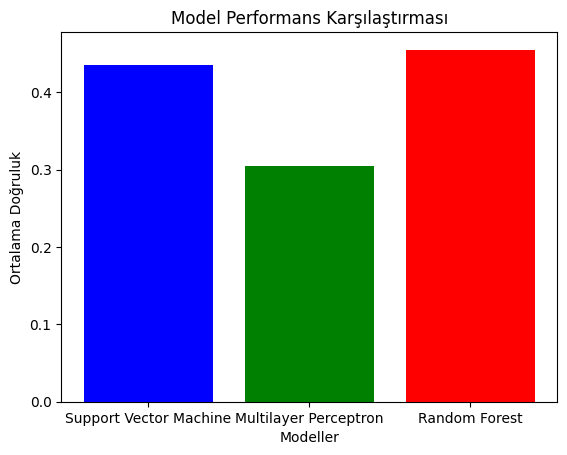

In [29]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC  # SVM modelini ekledik
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Veri setini işleme
def load_data(data_dir, target_size=(128, 128)):
    datagen = ImageDataGenerator(rescale=1.0 / 255)
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=1,
        class_mode="sparse",
        shuffle=False
    )

    images = []
    labels = []

    for i in range(len(generator.filenames)):
        img, label = next(generator)  # .next() yerine Python'un yerleşik next() fonksiyonu kullanılıyor
        images.append(img[0])  # İlk batch'in ilk görselini al
        labels.append(label)   # İlk batch'in etiketini al

    images = np.array(images)
    labels = np.array(labels)

    return images, labels, generator.class_indices

# Veriyi yükle
data_dir = "processed_images"  # Verilerinizin bulunduğu klasör
images, labels, class_mapping = load_data(data_dir)
print(f"Veri boyutu: {images.shape}, Etiket boyutu: {labels.shape}")
print(f"Sınıflar: {class_mapping}")

# Verileri düzleştir (Flatten)
X = images.reshape(images.shape[0], -1)  # Görüntüleri 1D vektöre dönüştür
y = labels

# Çapraz doğrulama ayarları
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Modelleri tanımla
models = {
    "Support Vector Machine": SVC(kernel="rbf", probability=True),  # SVM modelini ekledik
    "Multilayer Perceptron": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Her model için sonuçları sakla
results = {}

for model_name, model in models.items():
    print(f"\nModel: {model_name}")
    fold_accuracies = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Eğitim ve test bölmeleri
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Modeli eğit
        model.fit(X_train, y_train)

        # Tahmin yap
        y_pred = model.predict(X_test)

        # Doğruluk oranını hesapla
        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)

        print(f"Fold {fold + 1} Doğruluk: {accuracy:.4f}")

    # Ortalama doğruluğu hesapla
    mean_accuracy = np.mean(fold_accuracies)
    results[model_name] = mean_accuracy
    print(f"Model: {model_name}, Ortalama Doğruluk: {mean_accuracy:.4f}")

    # Modeli kaydet
    joblib.dump(model, f'{model_name.lower().replace(" ", "_")}_model.pkl')

# Sonuçları karşılaştır
print("\n=== Model Karşılaştırması ===")
for model_name, accuracy in results.items():
    print(f"{model_name}: Ortalama Doğruluk = {accuracy:.4f}")

# Sonuçları görselleştir
model_names = list(results.keys())
accuracies = list(results.values())

plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Modeller')
plt.ylabel('Ortalama Doğruluk')
plt.title('Model Performans Karşılaştırması')
plt.show()

In [31]:
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from urllib.request import urlretrieve

# Klasör oluşturma
def create_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

# Selenium ile Trendyol'dan görselleri indir
def download_images_unique(base_url, output_folder, num_pages=5):
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

    create_folder(output_folder)
    downloaded_urls = set()  # İndirilen görsellerin URL'lerini takip etmek için bir set

    for page in range(1, num_pages + 1):
        url = f"{base_url}?pi={page}"
        driver.get(url)
        time.sleep(3)

        images = driver.find_elements(By.CSS_SELECTOR, "img.p-card-img")
        for idx, img in enumerate(images):
            img_url = img.get_attribute("src")
            if img_url and "product-placeholder" not in img_url and img_url not in downloaded_urls:
                file_name = os.path.join(output_folder, f"image_page{page}_{idx + 1}.jpg")
                try:
                    urlretrieve(img_url, file_name)
                    downloaded_urls.add(img_url)  # URL'yi indirilenlere ekle
                    print(f"İndirildi: {file_name}")
                except Exception as e:
                    print(f"İndirilemedi: {img_url}, Hata: {e}")
            elif img_url in downloaded_urls:
                print(f"Tekrarlanan URL atlandı: {img_url}")

    driver.quit()

# Kullanım
base_url = "https://www.trendyol.com/kadin-ayakkabi-x-g1-c114"
output_folder = "test_images"
download_images_unique(base_url, output_folder, num_pages=5)

İndirildi: test_images\image_page1_1.jpg
İndirildi: test_images\image_page1_2.jpg
İndirildi: test_images\image_page1_3.jpg
İndirildi: test_images\image_page1_4.jpg
İndirildi: test_images\image_page1_5.jpg
İndirildi: test_images\image_page1_6.jpg
İndirildi: test_images\image_page1_7.jpg
İndirildi: test_images\image_page1_8.jpg
İndirildi: test_images\image_page1_9.jpg
İndirildi: test_images\image_page1_10.jpg
İndirildi: test_images\image_page1_11.jpg
İndirildi: test_images\image_page1_12.jpg
İndirildi: test_images\image_page1_13.jpg
İndirildi: test_images\image_page1_14.jpg
İndirildi: test_images\image_page1_15.jpg
İndirildi: test_images\image_page1_16.jpg
İndirildi: test_images\image_page1_17.jpg
İndirildi: test_images\image_page1_18.jpg
İndirildi: test_images\image_page1_19.jpg
İndirildi: test_images\image_page1_20.jpg
İndirildi: test_images\image_page1_21.jpg
İndirildi: test_images\image_page1_22.jpg
İndirildi: test_images\image_page1_23.jpg
İndirildi: test_images\image_page1_24.jpg
İ

In [24]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Sınıf isimlerini tanımlayın
class_names = ["Babet", "Bot", "Sneaker", "Topuklu Ayakkabı"]  # Modelinizin eğitim sırasında öğrendiği sınıf isimlerini buraya yazın

# Modeli yükle
#model = joblib.load('random_forest_model.pkl')
model = tf.keras.models.load_model("shoe_classifier_model.keras")

# Görselleri klasör olarak sınıflandırma fonksiyonu
def classify_images(input_folder, model, class_names, target_size=(128, 128)):
    images = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith(".jpg")]
    results = []

    for img_path in images:
        try:
            # Görseli yükle ve işle
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle
            img_array = img_array / 255.0  # Normalizasyon

            # Tahmin yap
            predictions = model.predict(img_array)
            predicted_class_index = np.argmax(predictions, axis=1)[0]
            predicted_class_name = class_names[predicted_class_index]  # Sınıf ismini al

            results.append((img_path, predicted_class_name))
            print(f"Görsel: {img_path}, Tahmin Edilen Sınıf: {predicted_class_name}")
        except Exception as e:
            print(f"Hata: {img_path}, {e}")

    return results

# Görselleri sınıflandır
classified_results = classify_images("test_images", model, class_names)

# Sonuçları ayrı klasörlere kaydetme fonksiyonu
def save_classified_images(results, output_folder):
    create_folder(output_folder)
    for img_path, predicted_class in results:
        class_folder = os.path.join(output_folder, predicted_class)  # Sınıf adıyla klasör oluştur
        create_folder(class_folder)
        os.rename(img_path, os.path.join(class_folder, os.path.basename(img_path)))

# Sonuçları kaydet
save_classified_images(classified_results, "classified_trendyol_images")


Modelleri Test Ediliyor...
Hata: test_images\image_page1_1.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_10.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_11.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_12.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_13.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_14.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_15.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_16.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_17.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_18.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_19.jpg, Found array with dim 4. SVC expected <= 2.
Hata: test_images\image_page1_2.jpg, Found array with dim 4. SVC expected <= 2.
Ha

ValueError: Found array with dim 4. RandomForestClassifier expected <= 2.